(Harry Forest)

(i6177374)

(Harry Forest)

# Data Analysis

# Clinic 2: Regress the price!

## DELIVERABLES (DEADLINE 25/February late night, wildcards possible)

Instructions for the deliverable: 

* Make sure that you include a proper amount/mix of comments, results and code.

* In the end, make sure that all cells are executed properly and everything you need to show is in your (execucted) notebook.

* You are asked to deliver **only your executed notebook file, .ipnyb** and nothing else. Enjoy!

* The second part of the assignment is purposefully left open-ended.  You will be allowed to build a linear model of your choice to compete against your peers in an in-class Kaggle competition.  **DO NOT PUT THIS ASSIGNMENT OFF TO THE LAST MOMENT AS THERE IS A CAP ON DAILY KAGGLE SUBMISSIONS**

* Honor code applies to these tasks. Only individual work should be submitted.

* Data science is a collaborative activity. While you may talk with others about the clinic, we ask that you **write your solutions individually**. If you do discuss the assignments with others please **include their names** below.

**Names of collaborators**: 

# 0. Introduction

In this clinic, we will go through the iterative process of specifying, fitting, and refining a model.  

In the first part of the assignment, we will guide you through some basic EDA, laying out the thought process that leads to certain modeling decisions.  We will then specify and fit more linear models, providing an example of the type of code we expect from you in the open-response.

The second part of the assignment is purposefully left open-ended.  You will be allowed to build a linear model of your choice to compete against your peers in an in-class Kaggle competition. **DO NOT PUT THIS ASSIGNMENT OFF TO THE LAST MOMENT AS THERE IS A CAP ON DAILY KAGGLE SUBMISSIONS**

After this homework, you should feel comfortable with the following:

1. Working with a messy data set that requires a moderate amount of cleaning and wrangling
1. Using `sklearn' to build models
1. Using several different transformations on your data
1. Building a data pipeline using pandas
1. Using cross-validation for model selection

## Score breakdown

Question | Points
--- | ---
[Question 1a](#q1a) | 2
[Question 1b](#q1b) | 3
[Question 2](#q2) | 5
[Question 3](#q3) | 25
[Question 4](#q4) | 5
[Question 5](#q5) | 5
[Question 6](#q6) | 5
Total | 50

This score will be scaled down to 1 and that will be your final clinic score.

In [1]:
#necessary imports (edit as you see fit)
import numpy as np

import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

## 0.1 The Data

The datset consists of 2930 records for house prices. The data are real and stem from the Ames Assessor's Office. They were used in computing assessed values for individual residential properties sold in Ames, IA from 2006 to 2010. The data set has 23 nominal, 23 ordinal, 14 discrete, and 20 continuous variables (and 2 additional observation identifiers) --- 82 features in total.  An explanation of each variable can be found in the included `codebook.txt` file. **Some noise has been added to the actual sale price, so prices will not match official records or other versions of the dataset to be found online, so don't try to cheat!**

The data are split into training and test sets with 2000 and 930 observations, respectively.  The actual sale price is withheld from you in the test set.  In addition, the test data are further split into public and private test sets.  When you upload a test set prediction onto Kaggle for validation, the score you receive will be calculated using the public test set.  The private test set will be used in a final evaluation of this homework assignment.

### 0.1.1 A little bit on the background on these house pricing datasets
In the United States, all property owners are required to pay property taxes, which are then used to fund public services including education, road maintenance, and sanitation. These property tax assessments are based on property values estimated using statistical models that consider multiple factors, such as real estate value and construction cost.

This system, however, is not without flaws. In late 2017, a lawsuit was filed against the office of Cook County Assessor Joseph Berrios for producing [“racially discriminatory assessments and taxes."](https://www.chicagotribune.com/politics/ct-cook-county-board-assessor-berrios-met-20170718-story.html) The lawsuit included claims that the assessor’s office undervalued high-priced homes and overvalued low-priced homes, creating a visible divide along racial lines: Wealthy homeowners, who were typically white, [paid less in property taxes](https://www.clccrul.org/bpnc-v-berrios-facts?rq=berrios), whereas [working-class, non-white homeowners paid more](https://www.chicagotribune.com/news/breaking/ct-cook-county-assessor-berrios-sued-met-20171214-story.html).

The Chicago Tribune's four-part series, ["The Tax Divide"](https://www.chicagotribune.com/investigations/ct-tax-divide-investigation-20180425-storygallery.html), delves into how this was uncovered: After "compiling and analyzing more than 100 million property tax records from the years 2003 through 2015, along with thousands of pages of documents, then vetting the findings with top experts in the field," they discovered that "residential assessments [had] been so far off the mark for so many years." You can read more about their investigation [here](https://apps.chicagotribune.com/news/watchdog/cook-county-property-tax-divide/assessments.html).

Additionally, the discrimination described in the lawsuit is built on a much deeper history - including the practice of redlining in Chicago. Though this is by no means a comprehensive history, Merriam-Webster defines redlining as the "withholdding of home-loan funds or insurance from neighborhoods considered poor economic risks." The neighborhoods in this category, however, were typically comprised of Black communities; redlining, then, systemically prevented Black residents from moving into other neighborhoods and improving their current homes by denying them the financial assistance that white residents were afforded. Though the Fair Housing Act of 1968 outlawed redlining, its [impacts](https://www.washingtonpost.com/news/wonk/wp/2018/03/28/redlining-was-banned-50-years-ago-its-still-hurting-minorities-today/) and [practices](https://www.chicagotribune.com/business/ct-biz-modern-day-redlining-20180215-story.html) are still present today.

This context is vital to understanding how different datasets might be created. This introduction aims to address how legacies of racial discrimination practices can be encoded within data, as well as consider how they might influence modeling choices.

In [2]:
training_data = pd.read_csv("ames_train.csv")
test_data = pd.read_csv("ames_test.csv")

As a good sanity check, we should at least verify that the data shape matches the description.

In [3]:
# 2000 observations and 82 features in training data
assert training_data.shape == (2000, 82)
# 930 observations and 81 features in test data
assert test_data.shape == (930, 81)
# SalePrice is hidden in the test data
assert 'SalePrice' not in test_data.columns.values
# Every other column in the test data should be in the training data
assert len(np.intersect1d(test_data.columns.values, 
                          training_data.columns.values)) == 81

The next order of business is getting a feel for the variables in our data.  The Ames data set contains information that typical homebuyers would want to know.  A more detailed description of each variable is included in `codebook.txt`.  **You should take some time to familiarize yourself with the codebook before moving forward.**

In [4]:
training_data.columns.values

array(['Order', 'PID', 'MS_SubClass', 'MS_Zoning', 'Lot_Frontage',
       'Lot_Area', 'Street', 'Alley', 'Lot_Shape', 'Land_Contour',
       'Utilities', 'Lot_Config', 'Land_Slope', 'Neighborhood',
       'Condition_1', 'Condition_2', 'Bldg_Type', 'House_Style',
       'Overall_Qual', 'Overall_Cond', 'Year_Built', 'Year_Remod/Add',
       'Roof_Style', 'Roof_Matl', 'Exterior_1st', 'Exterior_2nd',
       'Mas_Vnr_Type', 'Mas_Vnr_Area', 'Exter_Qual', 'Exter_Cond',
       'Foundation', 'Bsmt_Qual', 'Bsmt_Cond', 'Bsmt_Exposure',
       'BsmtFin_Type_1', 'BsmtFin_SF_1', 'BsmtFin_Type_2', 'BsmtFin_SF_2',
       'Bsmt_Unf_SF', 'Total_Bsmt_SF', 'Heating', 'Heating_QC',
       'Central_Air', 'Electrical', '1st_Flr_SF', '2nd_Flr_SF',
       'Low_Qual_Fin_SF', 'Gr_Liv_Area', 'Bsmt_Full_Bath',
       'Bsmt_Half_Bath', 'Full_Bath', 'Half_Bath', 'Bedroom_AbvGr',
       'Kitchen_AbvGr', 'Kitchen_Qual', 'TotRms_AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace_Qu', 'Garage_Type', 'Garage_Yr_Blt',

# 1. Guided Modeling

In the first part of the assignment, we will take you step-by-step through one cycle of the modeling process.  Along the way, we will provide commentary to give you a sense of the thought process that goes into building a model. We give examples on most of the common cases we have explored (EDA, missing values, feature engineering etc.), but feel free to extend this analyses for your final model.

## 1.1 EDA
Naturally, the first thing we want to do is get a feel for our data.  In this section, we will make a series of exploratory visualizations.  The plots we ask you to reproduce here are far from exhaustive. **When you build your own model in the second part of this assignment, you will want to delve deeper into the data.**

Note that we will perform EDA on the **training data** so that information from the test data does not influence our modeling decisions.

### 1.1.1 Sale Price
We begin by examining a [raincloud plot](https://micahallen.org/2018/03/15/introducing-raincloud-plots/amp/?__twitter_impression=true) (yet another name for a combination of a KDE, a boxplot, and a boxplot all-in-one) of our target variable `SalePrice`.  At the same time, we also take a look at some descriptive statistics of this variable.

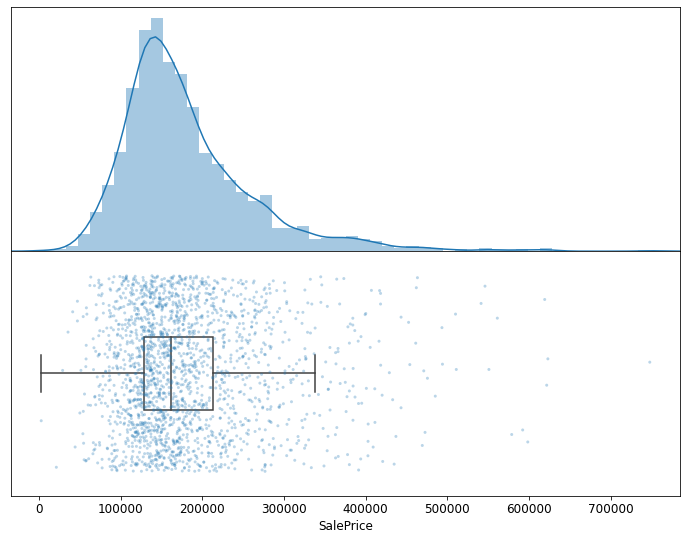

In [5]:
fig, axs = plt.subplots(nrows=2)

sns.distplot(
    training_data['SalePrice'], 
    ax=axs[0]
)
sns.stripplot(
    training_data['SalePrice'], 
    jitter=0.4, 
    size=3,
    ax=axs[1],
    alpha=0.3
)
sns.boxplot(
    training_data['SalePrice'],
    width=0.3, 
    ax=axs[1],
    showfliers=False,
)

# Align axes
spacer = np.max(training_data['SalePrice']) * 0.05
xmin = np.min(training_data['SalePrice']) - spacer
xmax = np.max(training_data['SalePrice']) + spacer
axs[0].set_xlim((xmin, xmax))
axs[1].set_xlim((xmin, xmax))

# Remove some axis text
axs[0].xaxis.set_visible(False)
axs[0].yaxis.set_visible(False)
axs[1].yaxis.set_visible(False)

# Put the two plots together
plt.subplots_adjust(hspace=0)

# Adjust boxplot fill to be white
axs[1].artists[0].set_facecolor('white')

In [6]:
#Summary statistics for price
training_data['SalePrice'].describe()

count      2000.000000
mean     180775.897500
std       81581.671741
min        2489.000000
25%      128600.000000
50%      162000.000000
75%      213125.000000
max      747800.000000
Name: SalePrice, dtype: float64

To check your understanding of the graph and summary statistics above, answer the following `True` or `False` questions:

1. The distribution of `SalePrice` in the training set is left-skew. False
1. The mean of `SalePrice` in the training set is greater than the median. True
1. 75% of the houses in the training set sold for less than \$213,125.00. True

If you have trouble answering the questions above, discuss them in class with each other and confirm with a TA

### 1.1.2 SalePrice vs Gr_Liv_Area

Next, we examine `SalePrice` vs `Gr_Liv_Area`.  Now it's not entirely obvious what `Gr_Liv_Area` should be, so we'll need to consult `codebook.txt`.  We find:

```
Gr Liv Area (Continuous): Above grade (ground) living area square feet
```

Ok, so this variable represents the square footage of the house excluding anything built underground.  Some additional research (into real estate conventions) reveals that this value also excludes the garage space.

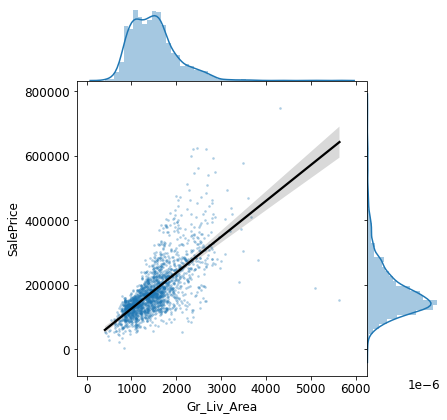

In [7]:
sns.jointplot(
    x='Gr_Liv_Area', 
    y='SalePrice', 
    data=training_data,
    stat_func=None,
    kind="reg",
    ratio=4,
    space=0,
    scatter_kws={
        's': 3,
        'alpha': 0.25
    },
    line_kws={
        'color': 'black'
    }
)

We notice that there is a plausible linear relationship between house size and sale price, but the spread is wider at larger sale prices and above grade living areas.  There seem to be two particularly suspicious houses above 5000 square feet.

What do we do when we have outliers? Let's check them properly!

What are the Parcel Indentification Numbers for the two houses with `Gr_Liv_Area` greater than 5000 sqft? That's something that can be answered just through Pandas

In [8]:
# Hint: You can answer this question purely through pandas
# q2house1 and q2house2 should be integers
q2house1 = training_data["PID"][training_data["Gr_Liv_Area"] > 5000].iloc[0].item()
q2house2 = training_data["PID"][training_data["Gr_Liv_Area"] > 5000].iloc[1].item()

pd.set_option('mode.chained_assignment', None) 
q2house1,q2house2

(908154235, 908154195)

The codebook actually tells us how to manually inspect the houses using an online database called Beacon. These two houses are true outliers in this data set.  They were partial sales that were priced much under market value.  We will remove them in the guided model, but perhaps you will want to address them differently in your own model.  To make sure you know how to view the online database, please answer the following question:

What are the gross values of the two houses with `Gr_Liv_Area` greater than 5000 as of 2017?  You will find this under the section titled "Valuation (Ames)".  Your answers should be integers.

In [9]:
q3house1 = 1169500
q3house2 = 1104100

Below we write a function `remove_outliers` that removes outliers from a data set based off a threshold value of a variable. For example, `remove_outliers(training_data, 'Gr_Liv_Area', upper=5000)` should return a data frame with only observations that satisfy `Gr_Liv_Area` less than or equal to 5000.

In [10]:
def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    """
    Input:
      data (data frame): the table to be filtered
      variable (string): the column with numerical outliers
      lower (numeric): observations with values lower than this will be removed
      upper (numeric): observations with values higher than this will be removed
    
    Output:
      a winsorized data frame with outliers removed
    """
    return data.loc[(data[variable] > lower) & (data[variable] < upper)]


training_data = remove_outliers(training_data, 'Gr_Liv_Area', upper=5000)

In [11]:
#making sure the two observations were removed
assert training_data.shape[0] == 1998

### 1.1.3 Neighborhood vs Sale Price

next we explore this

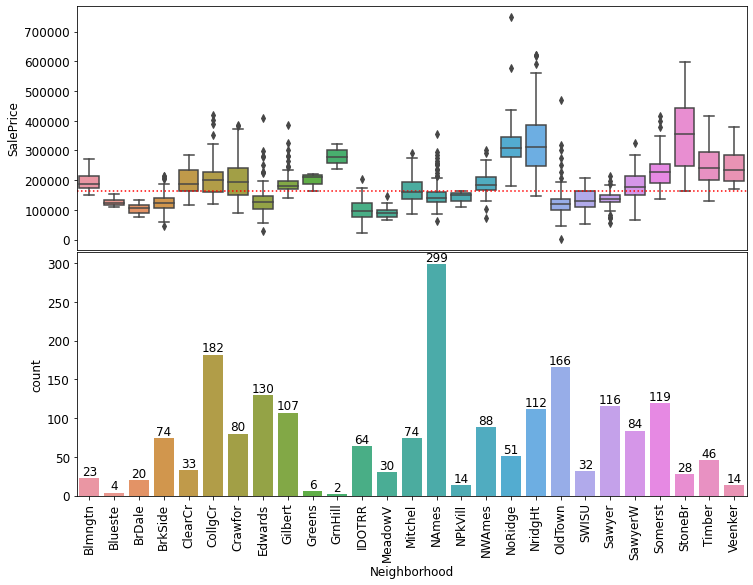

In [12]:
fig, axs = plt.subplots(nrows=2)

sns.boxplot(
    x='Neighborhood',
    y='SalePrice',
    data=training_data.sort_values('Neighborhood'),
    ax=axs[0]
)

sns.countplot(
    x='Neighborhood',
    data=training_data.sort_values('Neighborhood'),
    ax=axs[1]
)

# Draw median price
axs[0].axhline(
    y=training_data['SalePrice'].median(), 
    color='red',
    linestyle='dotted'
)

# Label the bars with counts
for patch in axs[1].patches:
    x = patch.get_bbox().get_points()[:, 0]
    y = patch.get_bbox().get_points()[1, 1]
    axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')
    
# Format x-axes
axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
axs[0].xaxis.set_visible(False)

# Narrow the gap between the plots
plt.subplots_adjust(hspace=0.01)

From the plot above, it becomes clear that there is quite some variation in prices across neighborhoods.  Moreover, the amount of data available is not uniformly distributed among neighborhoods.  North Ames, for example, comprises almost 15% of the training data while Green Hill has a scant 2 observations in this data set.

One way we can deal with the lack of data from some neighborhoods is to create a new feature that bins neighborhoods together.  Let's dichotomize our neighborhoods in a very crude way: we'll take the top 3 neighborhoods measured by median `SalePrice` and identify them as "rich neighborhoods"; the other neighborhoods are not marked.

Now we write a function that returns list of the top-$n$ most pricey neighborhoods as measured by our choice of aggregating function.  For example, in the setup above, we would want to call `find_rich_neighborhoods(training_data, 3, np.median)` to find the top 3 neighborhoods measured by median `SalePrice`.

In [13]:
def find_rich_neighborhoods(data, n=3, metric=np.median):
    """
    Input:
      data (data frame): should contain at least a string-valued Neighborhood
        and a numeric SalePrice column
      n (int): the number of top values desired
      metric (function): function used for aggregating the data in each neighborhood.
        for example, np.median for median prices
    
    Output:
      a list of the top n richest neighborhoods as measured by the metric function
    """
    neighborhoods = data.groupby("Neighborhood").agg(metric).sort_values(by=["SalePrice"],ascending=False).iloc[:n].index.values.tolist()
    return neighborhoods

rich_neighborhoods = find_rich_neighborhoods(training_data, 3, np.median)
rich_neighborhoods

['StoneBr', 'NridgHt', 'NoRidge']

In [14]:
# Check to see if the n argument works
assert len(find_rich_neighborhoods(training_data, 5, np.median)) == 5
assert isinstance(rich_neighborhoods, list)
# Check to see if the list contains only strings
assert all([isinstance(neighborhood, str) for neighborhood in rich_neighborhoods])

## 1.2 Missing Data

Let's see if our data set has any missing values.  Create a Series object containing the counts of missing values in each of the columns of our data set sorted from greatest to least.  The Series should be indexed by the variable names. For example, `missing_counts['Fireplace_Qu']` should return 975.

In [15]:
missing_counts = len(training_data.index) - training_data.count()

In [16]:
# Make sure your answer is a Series
assert isinstance(missing_counts, pd.Series)
# Make sure all columns are represented
assert missing_counts.size == 82
# Make sure your index values match column names
assert set(missing_counts.index.values) == set(training_data.columns.values)

It turns out that if we look at the codebook carefully, some of these "missing values" aren't missing at all! The Assessor's Office just used `NA` to denote a special value or that the information was truly not applicable for one reason or another.  One such example is the `Fireplace_Qu` variable.
```
FireplaceQu (Ordinal): Fireplace quality

       Ex	Excellent - Exceptional Masonry Fireplace
       Gd	Good - Masonry Fireplace in main level
       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace inbasement
       Fa	Fair - Prefabricated Fireplace in basement
       Po	Poor - Ben Franklin Stove
       NA	No Fireplace
```

An `NA` here actually means that the house had no fireplace to rate.  Let's fix this in our data set.  Write a function that replaces the missing values in `Fireplace_Qu` with `'No Fireplace'`.  In addition, it should replace each abbreviated condition with its full word.  For example, `'TA'` should be changed to `'Average'`.  Hint: the [DataFrame.replace](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.replace.html) method may be useful here.


In [17]:
def fix_fireplace_qu(data):
    """
    Input:
      data (data frame): a data frame containing a Fireplace_Qu column.  Its values
                         should be limited to those found in the codebook
    Output:
      data frame identical to the input except with a refactored Fireplace_Qu column
    """
    dictz = {
        "Ex":"Excellent",
        "Gd":"Good",
        "TA":"Average",
        "Fa": "Fair",
        "Po": "Poor",
    }
    data['Fireplace_Qu'] = data['Fireplace_Qu'].replace(dictz)
    data['Fireplace_Qu'] = data['Fireplace_Qu'].fillna(value="No Fireplace")
    return data

training_data = fix_fireplace_qu(training_data)

In [18]:
# Make sure you've replaced all the missing values with 'No Fireplace'
assert sum(training_data['Fireplace_Qu'] == 'No Fireplace') == 975

It turns out that simply fixing these missing values isn't sufficient for using `Fireplace_Qu` in our model.  Since `Fireplace_Qu` is a categorical/nominal variable, we will have to one-hot-encode the data.  Notice in the example code below that we have to pre-specify the categories.  Why? Imagine what would happen if we automatically generated the categories only from the training data.  What would happen if the testing data contained a category not found in the training set?  For more information on categorical data in pandas, refer to this [link](https://pandas-docs.github.io/pandas-docs-travis/categorical.html).  **Note that `get_dummies` removes the original column.**

In [19]:
def ohe_fireplace_qu(data):
    """
    One-hot-encodes fireplace quality.  New columns are of the form fpq_QUALITY
    """
    cats = [
        'Excellent',
        'Good',
        'Average',
        'Fair',
        'Poor',
        'No Fireplace'
    ]
    
    cat_type = CategoricalDtype(categories=cats)
    
    data['Fireplace_Qu'] = data['Fireplace_Qu'].astype(cat_type)
    data = pd.get_dummies(data,
                          prefix='fpq',
                          columns=['Fireplace_Qu'], 
                          drop_first=True)
    
    return data

In [20]:
training_data = ohe_fireplace_qu(training_data)
training_data.filter(regex='fpq').head(10)

,fpq_Good,fpq_Average,fpq_Fair,fpq_Poor,fpq_No Fireplace
0,1,0,0,0,0
1,0,0,0,0,1
2,0,0,0,0,1
3,0,1,0,0,0
4,0,1,0,0,0
5,1,0,0,0,0
6,0,0,0,0,1
7,0,1,0,0,0
8,0,0,0,0,1
9,1,0,0,0,0


## 1.3 Feature Engineering

In this section we will create a new feature out of existing ones through a simple data transformation.  When you move on to create your own model, you may want to try out more complex transformations.

### 1.3.1 Bathrooms

We will create a groundbreaking new feature. Due to recent advances in Universal WC Enumeration Theory, we now know that Total Bathrooms can be calculated as:

$$ TotalBathrooms=(BsmtFullBath + FullBath) + \dfrac{1}{2}(BsmtHalfBath + HalfBath)$$

The actual proof is beyond the scope of this class, but we will use the result in our model.

We write a function `add_total_bathrooms(data)` that returns the input data frame with a new column called `total_bathrooms` as calculated above. Note that we Treat missing values as 0s and we make extensive use of vectorized code.

In [21]:
def add_total_bathrooms(data):
    """
    Input:
      data (data frame): a data frame containing at least 4 numeric columns 
            Bsmt_Full_Bath, Full_Bath, Bsmt_Half_Bath, and Half_Bath
    Output:
      data frame identical to the input with the addition of a total_bathrooms column
    """
    a = data.loc[:,"Bsmt_Full_Bath"].fillna(value=0)
    b = data.loc[:,"Full_Bath"].fillna(value=0)
    c = 0.5*data.loc[:,"Bsmt_Half_Bath"].fillna(value=0)
    d = 0.5*data.loc[:,"Half_Bath"].fillna(value=0)
    data["total_bathrooms"] = a+b+c+d
    return data

training_data = add_total_bathrooms(training_data)

In [22]:
# Check that missing values are dealt with
assert ~training_data['total_bathrooms'].isnull().any()
# Check that the values are as expected
assert training_data['total_bathrooms'].sum() == 4421.5

### 1.3.2 Rich Neighborhoods

From before, we have a list of neighborhoods we've deemed as richer than others.  Let's use that information to make a new variable `in_rich_neighborhood`. We write a function `add_rich_neighborhood` that adds an indicator variable which takes on the value 1 if the house is part of `rich_neighborhoods` and the value 0 otherwise.

In [23]:
def add_in_rich_neighborhood(data, neighborhoods):
    """
    Input:
      data (data frame): a data frame containing a 'Neighborhood' column with values
        found in the codebook
      neighborhoods (list of strings): strings should be the names of neighborhoods
        pre-identified as rich
    Output:
      data frame identical to the input with the addition of a binary
      in_rich_neighborhood column
    """
    data["in_rich_neighborhood"] = 0
    mask = data["Neighborhood"].isin(neighborhoods)
    data.loc[mask,"in_rich_neighborhood"] = 1
    return data

rich_neighborhoods = find_rich_neighborhoods(training_data, 3, np.median)
training_data = add_in_rich_neighborhood(training_data, rich_neighborhoods)

In [24]:
# Check to see if you have identified the correct number of rich neighborhoods
assert sum(training_data['in_rich_neighborhood']) == 191
# Check to see if you've introduced any missing values
assert sum(training_data['in_rich_neighborhood'].isnull()) == 0

# 2. Modeling

We've finally gotten to a point where we can specify a simple model.  But first, we need to create perform a test-train split of our data.  We begin by loading a fresh copy of the data in at this point just in case our code above produced any undesired side-effects.  At this point, we will begin to treat `ames_train.csv` as our complete data set.  We will use `train_test_split` from `sklearn` to split the data into `test` and `train` sets.

Remember: The reason we have to do a train-test split on `ames_train.csv` here is because we want to evaluate how well our model might perform on future data (`ames_test.csv`), but that data set does not have `SalePrice` in it!

In [25]:
# Load a fresh copy of the data
full_data = pd.read_csv("ames_train.csv")

# This makes the train-test split in this section reproducible across different runs 
# of the notebook.  You do not need this line to run train_test_split in general
np.random.seed(1337) 

# Split the data 
train, test = train_test_split(full_data, test_size=0.2)

In [26]:
# Something has gone awry in the cell above if these do not pass
assert test.shape == (400, 82)
assert train.shape == (1600, 82)
assert train.loc[887, 'PID'] == 902402260

## 2.1 Reusable Pipeline

Throughout this assignment, you should notice that your data flows through a single processing pipeline several times.  From a software engineering perspective, this should be sufficient motivation to abstract parts of our code into reusable functions/methods.  We will now encapsulate our entire pipeline into a single function `process_data_gm`.  gm is shorthand for "guided model".

In [27]:
def select_columns(data, *columns):
    return data.reindex(columns = columns)
    #deprecated:
    #return data.loc[:, columns]

def process_data_gm1(data):
    # Clean Data
    data = remove_outliers(data, 'Gr_Liv_Area', upper=5000)
    data = fix_fireplace_qu(data)
    
    # Transform Data
    data = add_total_bathrooms(data)
    data = add_in_rich_neighborhood(data, rich_neighborhoods)
    data = select_columns(data, 
                          'SalePrice', 
                          'Gr_Liv_Area', 
                          'total_bathrooms',
                          'Fireplace_Qu',
                          'in_rich_neighborhood'
                         )
    data = ohe_fireplace_qu(data)
    
    # Return predictors and response variables separately
    X = data.drop(['SalePrice'], axis = 1)
    y = data['SalePrice']
    
    return X, y

An alternative way of writing the same code above explicitly allows us to think about our data flowing through a [pipeline](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.pipe.html) where the output of one function is the input of the next.  Carefully thought out function names make the code self-documenting: you can just read off the intended high-level processing steps from top to bottom.

You are not required to use this style of coding.  We just wanted to point out that it exists.

In [28]:
def process_data_gm1(data):

    data = (
        data
        # Clean Data
        .pipe(remove_outliers, 'Gr_Liv_Area', upper=5000)
        .pipe(fix_fireplace_qu)
        
        # Transform data
        .pipe(add_total_bathrooms)
        .pipe(add_in_rich_neighborhood, rich_neighborhoods)
        .pipe(select_columns, 
              'SalePrice',           
              'Gr_Liv_Area',            
              'total_bathrooms',             
              'Fireplace_Qu',            
              'in_rich_neighborhood'
             )
        .pipe(ohe_fireplace_qu)
    ) 
    
    # Return predictors and response variables separately
    X = data.drop(['SalePrice'], axis = 1)
    y = data['SalePrice']
    
    return X, y

## 2.2 Fitting our first model

We are finally going to fit a model (yay!). This part is slightly unceremonious since we did much of the heavy lifting in the previous sections.  The model we will fit can be written as follows (with the caveat that one of the fireplace qualities is actually removed to avoid collinearity):

$$\begin{align} SalePrice = &\theta_0 + \theta_1 \times GrLivArea + \theta_2 \times TotalBathrooms \\
&+ \theta_3 \times InRichNeighborhood + \sum_{quality \in FireplaceQuality} \theta_{quality} \times Quality
\end{align}$$

#### Question 1a <a name="q1a"></a>
Remove the commenting and fill in the ellipses `...` below with `X_train`, `y_train`, `X_test`, or `y_test`.

In [29]:
# Pre-process our training and test data in exactly the same way
# Our functions make this very easy!
X_train ,y_train = process_data_gm1(train)
X_test, y_test = process_data_gm1(test)
guidedmodel1 = lm.LinearRegression(fit_intercept=True)

# Fill in the ... below with X_train, y_train, X_train, or X_test.
# Remember to uncomment
guidedmodel1.fit(X_train, y_train)
y_fitted = guidedmodel1.predict(X_train)
y_predicted = guidedmodel1.predict(X_test)

In [30]:
assert 181100 <= y_fitted.mean() <= 181400
assert 177700 <= y_predicted.mean() <= 177800

In this assignment, we will use Root-Mean-Square Error (RMSE) to measure the quality of our models.  As a reminder, this quantity is defined as:

$$RMSE = \sqrt{\dfrac{\sum_{\text{houses in test set}}(\text{actual price of house} - \text{predicted price of house})^2}{\text{# of houses in test set}}}$$

#### Question 1b <a name="q1b"></a>

Write a function `rmse` that calculates the RMSE of a model.  Again, make sure you are taking advantage of vectorized code.  This can be solved without any iteration.

In [31]:
def rmse(actual, predicted):
    """
    Calculates RMSE from actual and predicted values
    Input:
      actual (1D array-like): vector of actual values
      predicted (1D array-like): vector of predicted/fitted values
    Output:
      a float, the root-mean square error
    """
    ## your code here
    rmse = np.sqrt((sum((actual - predicted)**2)) / len(actual))
    return rmse



In [32]:
assert 43000 <= rmse(y_test, y_predicted) <= 44000

## 2.3 Checking our model: Residual Plots

Recall from the lectures, that one way of diagnosing a model is through a residual plot.  Here we plot the actual sale prices against the residuals of the model.  Ideally, we would see a horizontal line of points at 0 (perfect prediction!).  The next best thing would be a homogenous set of points centered at 0.  But alas, our simple model is probably too simple.  We notice that we are really underfitting the more expensive homes in the test set.  In fact, it looks like our model tends to underprice the more expensive homes!  You will probably want to address this in your own work.

Text(0, 0.5, 'Residuals (Actual Price - Predicted Price)')

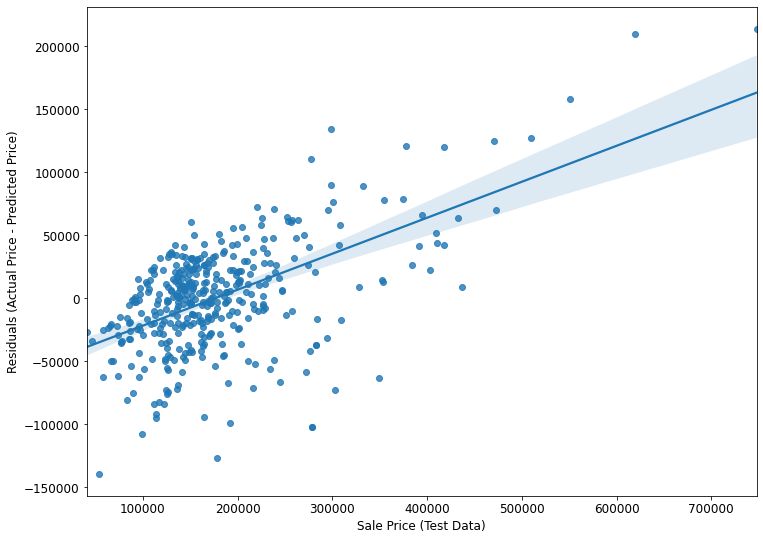

In [33]:
gm1_residuals = y_test - y_predicted
ax = sns.regplot(y_test, gm1_residuals)
ax.set_xlabel('Sale Price (Test Data)')
ax.set_ylabel('Residuals (Actual Price - Predicted Price)')

## 2.4 Regularizing our model

Ok, so let's make our modeling a little more fancy by regularizing the coefficients.  This second model will use the Lasso, but you are free to use Ridge or other in your work.  First, we need to add a step to our pre-processing.  In order for regularization to be fair to all the variables in our model, we need to standardize our predictor columns (otherwise it would unfairly penalize variables with inherently small values).

#### Question 2 <a name="q2"></a>

Write a function that standardizes the columns of a data frame containing only numeric columns.  Be sure to make use of vectorization.

In [34]:
def standardize_columns(data):
    '''
    Input:
      data (data frame): contains only numeric columns
    Output:
      data frame, the same data, except each column is standardized 
      to have 0-mean and unit variance
    '''
    #your code goes here
    standardized_data = (data - data.mean()) / data.std()
    return standardized_data

In [35]:
test_standardize_df = standardize_columns(training_data[['SalePrice', 'Gr_Liv_Area']])
# Make sure the mean is correct
assert -0.001 < test_standardize_df.mean().sum() < 0.001
# Make sure the standard deviation is correct
assert 1.9 < test_standardize_df.std().sum() < 2.1

We'll now use this function to describe our new processing for the regularized model.

In [36]:
def process_data_gm2(data):

    data = (
        data
        # Clean Data
        .pipe(remove_outliers, 'Gr_Liv_Area', upper=5000)
        .pipe(fix_fireplace_qu)
        
        # Transform data
        .pipe(add_total_bathrooms)
        .pipe(add_in_rich_neighborhood, rich_neighborhoods)
        .pipe(select_columns, 
              'SalePrice',           
              'Gr_Liv_Area',            
              'total_bathrooms',             
              'Fireplace_Qu',            
              'in_rich_neighborhood'
             )
        .pipe(ohe_fireplace_qu)
    ) 
    
    # Return predictor and response variables separately
    X = standardize_columns(data).drop(['SalePrice'], axis = 1)
    y = data['SalePrice']
    
    return X, y

It may be instructive to see the cross-validation procedure explicitly once.  You should be able to understand what each part of the code is doing below, but we do not expect you to use this code for your own model (use [LassoCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html) instead).

In [37]:
# Process our data
X_train, y_train = process_data_gm2(train)
X_test, y_test = process_data_gm2(test)

# Specify our model
guidedmodel2 = lm.Lasso(copy_X=True)

# Specify CV method and alpha grid
five_fold_cv = KFold(n_splits = 5)
alphas = np.arange(0.1, 200.1, .1)
rmses = np.zeros(len(alphas))

# Grid search over alphas
for i, alpha in enumerate(alphas):
    guidedmodel2.set_params(alpha=alpha)
    model_rmse = 0
    
    # Fit each fold using the other four as training data
    for train_index, test_index in five_fold_cv.split(X_train):
        X_fold_train = X_train.iloc[train_index]
        y_fold_train = y_train.iloc[train_index]
        X_fold_test = X_train.iloc[test_index]
        y_fold_test = y_train.iloc[test_index]
        
        guidedmodel2.fit(X_fold_train, y_fold_train)
        y_fold_predicted = guidedmodel2.predict(X_fold_test)
        model_rmse += rmse(y_fold_test, y_fold_predicted)
    
    # Average RMSE over the five folds for alpha_i
    rmses[i] = model_rmse / 5

optimal_alpha = alphas[rmses == np.min(rmses)]
guidedmodel2.set_params(alpha=optimal_alpha)
guidedmodel2.fit(X_train, y_train)
y_predicted = guidedmodel2.predict(X_test)

print(f'The validation RMSE for this model with '
      f'alpha={float(optimal_alpha)} is {rmse(y_test, y_predicted)}.')

The validation RMSE for this model with alpha=56.2 is 43520.036103137914.


### 2.4.1 Lasso Path

Let's take a look at how RMSE varied across different choices of the regularization hyperparameter ($\lambda$ in lecture, `alpha` in `sklearn`).  This is often called the Lasso or Regularization Path.  The dashed red line marks the alpha that minimizes RMSE.

Text(0, 0.5, 'RMSE')

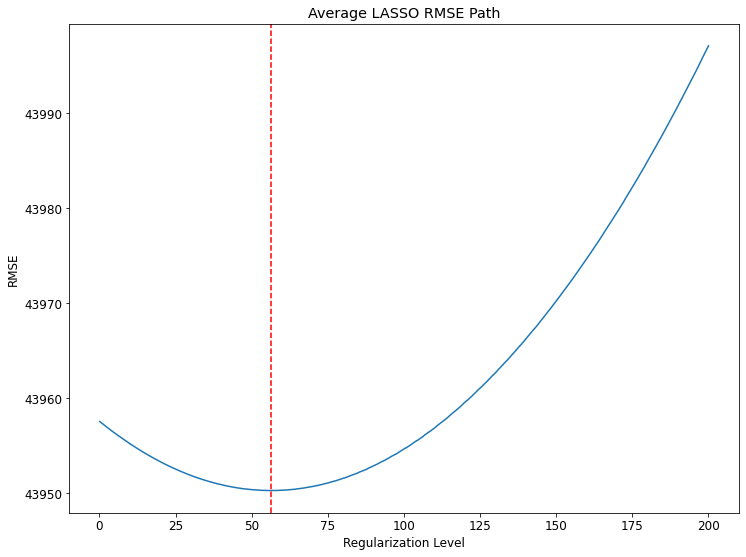

In [38]:
plt.plot(alphas, rmses)
plt.axvline(x=optimal_alpha, color='red', linestyle='dashed')
ax = plt.gca()
ax.set_title('Average LASSO RMSE Path')
ax.set_xlabel('Regularization Level')
ax.set_ylabel('RMSE')

### 2.4.2 A simplified approach to Lasso and CV

Here we perform another L1-regularized regression but using `LassoCV`.  This is more in line with what we expect from you code-wise.  That being said, you should still understand the concepts from the previous section.

In [39]:
# Process the data
X_train, y_train = process_data_gm2(train)
X_test, y_test = process_data_gm2(test)

# Specify the model, alphas, and number of folds for CV
alphas = np.arange(0.1, 200.1, .1)
guidedmodel2 = lm.LassoCV(alphas=alphas, cv=5)

# Fit and predict
guidedmodel2.fit(X_train, y_train)
y_predicted = guidedmodel2.predict(X_test)

print(f'The validation RMSE for this model with '
      f'alpha={round(float(guidedmodel2.alpha_), 2)} is '
      f'{round(rmse(y_test, y_predicted), 2)}.')

The validation RMSE for this model with alpha=55.8 is 43520.1.


Again, we can map out the path that the Lasso algorithm took.

Text(0, 0.5, 'RMSE')

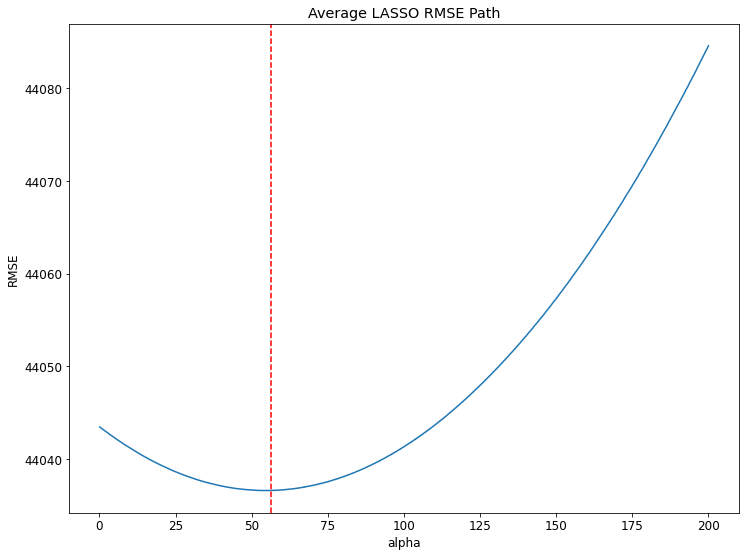

In [40]:
plt.plot(guidedmodel2.alphas_, np.sqrt(np.apply_along_axis(np.mean, 1, guidedmodel2.mse_path_)))
plt.axvline(x=optimal_alpha, color='red', linestyle='dashed')
ax = plt.gca()
ax.set_title('Average LASSO RMSE Path')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')

### 2.4.3 Lasso Residual Plot

Looking at the residual plot for our L1 regularized linear model, it's clear the regularization did not solve the problems we saw in the simple model.  It seems you have your work cut out for you!

Text(0, 0.5, 'Residuals (Actual Price - Predicted Price)')

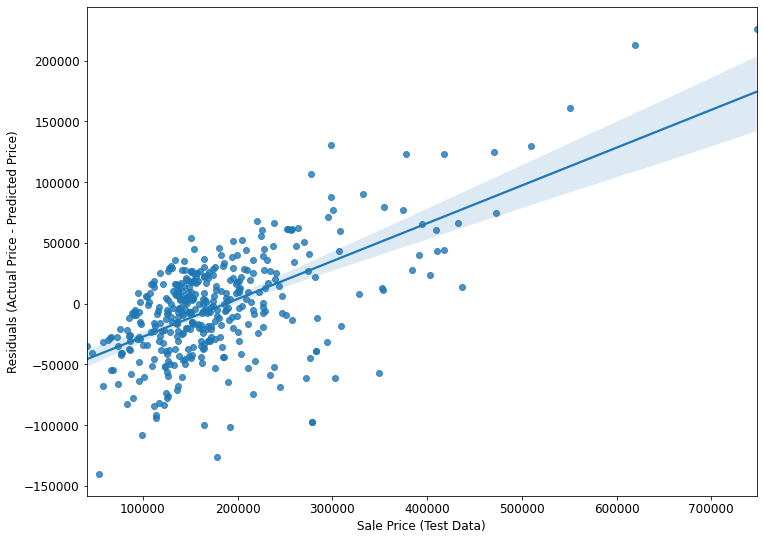

In [41]:
gm2_residuals = y_test - y_predicted
ax = sns.regplot(y_test, gm2_residuals)
ax.set_xlabel('Sale Price (Test Data)')
ax.set_ylabel('Residuals (Actual Price - Predicted Price)')

# 3. Open-Response

The second part of the assignment is purposefully left nearly open-ended. The data in your possession comes from a larger data set. Your goal is to provide a linear model (linear regression, Lasso, Ridge, or other) that accurately predicts the prices of the held-out homes, measured by root mean square error.  That is, the score you will see on the Kaggle leaderboard is calculated as follows:

$$score = \sqrt{\dfrac{\sum_{\text{houses in public test set}}(\text{actual price for house} - \text{predicted price for house})^2}{\text{# of houses}}}$$

Perfect prediction of house prices would have a score of 0, so you want your score to be as low as possible!

**Kaggle Submission Site:** https://www.kaggle.com/t/5f826d66795b4f9294764ab42547500c  
**Max number of submissions per day:** 10  
**Max number of final submissions:** 2

### Grading Scheme

Your grade for the open-response section will be based on 4 things: your training RMSE, your public test set RMSE (seen on Kaggle), and your private test set RMSE (hidden until the end of the competition). Some indicative thresholds are as follows. Keep in mind that we might adjust these thresholds so as to guarantee a fair grading for all:

#### RMSE
Points | 10 | 8 | 6 | 4 | 2 | 0
--- | --- | --- | --- | --- | --- | ---
Training RMSE | Less than 26k | 26k - 28k | 28k - 30k | 30k-35k | More than 35k | No work

Points | 10 | 8 | 6 | 4 | 2 | 0
--- | --- | --- | --- | --- | --- | ---
Public Test Set RMSE | Less than 27k | 27k - 30k | 30k - 33k | 33k-36k | More than 36k | No work

Points | 5 | 4 | 3 | 2 | 1 | 0
--- | --- | --- | --- | --- | --- | ---
Private Test Set RMSE | Less than 29k | 29k - 32k | 32k - 35k | 35k-38k | More than 38k | No work 

### Deliverables

#### Question 3 <a name="q3"></a>

Just as in the guided model above, you should encapsulate as much of your workflow into functions as possible.  Define `process_data_fm` and `final model` in the cell below.  In order to calculate your final model's RMSE, we will run the code in the cell after that.

**It is your duty to make sure that the code runs.** Double check your notebooks for typos/bugs. You can expect the data to be formatted like `ames_train.csv`.  `public_test_set.csv` and `private_test_set.csv` are both subsets of `ames_test.csv` (except that they both have the `SalePrice` column that was omitted from `ames_test.csv`).

In [541]:

  
        def fix_fireplace_qu(data):
    """
    Input:
      data (data frame): a data frame containing a Fireplace_Qu column.  Its values
                         should be limited to those found in the codebook
    Output:
      data frame identical to the input except with a refactored Fireplace_Qu column
    """
    dictz = {
        "Ex":"Excellent",
        "Gd":"Good",
        "TA":"Average",
        "Fa": "Fair",
        "Po": "Poor",
    }
    data['Fireplace_Qu'] = data['Fireplace_Qu'].replace(dictz)
    data['Fireplace_Qu'] = data['Fireplace_Qu'].fillna(value="No Fireplace")
    return data

def ohe_fireplace_qu(data):
    """
    One-hot-encodes fireplace quality.  New columns are of the form fpq_QUALITY
    """
    cats = [
        'Excellent',
        'Good',
        'Average',
        'Fair',
        'Poor',
        'No Fireplace'
    ]
    
    cat_type = CategoricalDtype(categories=cats)
    
    data['Fireplace_Qu'] = data['Fireplace_Qu'].astype(cat_type)
    data = pd.get_dummies(data,
                          prefix='fpq',
                          columns=['Fireplace_Qu'], 
                          drop_first=True)
    
    return data

def fix_kitchen_qual(data):
   
    dictz = {
        "Ex":"Excellent",
        "Gd":"Good",
        "TA":"Average",
        "Fa": "Fair",
        "Po": "Poor",
    }
    data['Kitchen_Qual'] = data['Kitchen_Qual'].replace(dictz)
    
    return data


def ohe_kitchen_qual(data):
    """
    One-hot-encodes fireplace quality.  New columns are of the form fpq_QUALITY
    """
    cats = [
        'Excellent',
        'Good',
        'Average',
        'Fair',
        'Poor',
        
    ]
    
    cat_type = CategoricalDtype(categories=cats)
    
    data['Kitchen_Qual'] = data['Kitchen_Qual'].astype(cat_type)
    data = pd.get_dummies(data,
                          prefix='kitch',
                          columns=['Kitchen_Qual'], 
                          drop_first=True)
    
    return data
def ohe_bsmt_Qual(data):
    cats = [
        'Ex',
        'Gd',
        'TA',
        'Fa',
        'Po',
        'NA',
    ]
    
    cat_type = CategoricalDtype(categories=cats)
    
    data['Bsmt_Qual'] = data['Bsmt_Qual'].astype(cat_type)
    data = pd.get_dummies(data,
                          prefix='bsmt',
                          columns=['Bsmt_Qual'], 
                          drop_first=True)
    
    return data



def ohe_heating_qc(data):
    cats = [
        'Ex',
        'Gd',
        'TA',
        'Fa',
        'Po',
        
    ]
    
    cat_type = CategoricalDtype(categories=cats)
    
    data['Heating_QC'] = data['Heating_QC'].astype(cat_type)
    data = pd.get_dummies(data,
                          prefix='heat',
                          columns=['Heating_QC'], 
                          drop_first=True)
    
    return data

def ohe_exter_qual(data):
    cats = [
        'Ex',
        'Gd',
        'TA',
        'Fa',
        'Po',
        
    ]
    
    cat_type = CategoricalDtype(categories=cats)
    
    data['Exter_Qual'] = data['Exter_Qual'].astype(cat_type)
    data = pd.get_dummies(data,
                          prefix='exterqual',
                          columns=['Exter_Qual'], 
                          drop_first=True)
    
    return data

def ohe_exter_cond(data):
    cats = [
        'Ex',
        'Gd',
        'TA',
        'Fa',
        'Po',
        
    ]
    
    cat_type = CategoricalDtype(categories=cats)
    
    data['Exter_Cond'] = data['Exter_Cond'].astype(cat_type)
    data = pd.get_dummies(data,
                          prefix='extercond',
                          columns=['Exter_Cond'], 
                          drop_first=True)
    
    return data

def ohe_bldg_type(data):
    cats = [
        '1Fam',
        '2FamCon',
        'Duplx',
        'twnhsE',
        'TwnhsI',
        'NA',
    ]
    
    cat_type = CategoricalDtype(categories=cats)
    
    data['Bldg_Type'] = data['Bldg_Type'].astype(cat_type)
    data = pd.get_dummies(data,
                          prefix='bld',
                          columns=['Bldg_Type'], 
                          drop_first=True)
    
    return data

def ohe_land_contour(data):
    cats = [
        'Lvl',
        'Bnk',
        'HLS',
        'Low',
    ]
    
    cat_type = CategoricalDtype(categories=cats)
    
    data['Land_Contour'] = data['Land_Contour'].astype(cat_type)
    data = pd.get_dummies(data,
                          prefix='LandConto',
                          columns=['Land_Contour'], 
                          drop_first=True)
    
    return data


def ohe_utilities(data):
    cats = [
        'AllPub',
        'NoSewr',
        'NoSeWa',
        'ELO',
    ]
    
    cat_type = CategoricalDtype(categories=cats)
    
    data['Utilities'] = data['Utilities'].astype(cat_type)
    data = pd.get_dummies(data,
                          prefix='utili',
                          columns=['Utilities'], 
                          drop_first=True)
    
    return data



def ohe_sale_cond(data):
    cats = [
        'Normal',
        'Abnorml',
        'AdjLand',
        'Alloca',
        'Family',
        'Partial'
    ]
    
    cat_type = CategoricalDtype(categories=cats)
    
    data['Sale_Condition'] = data['Sale_Condition'].astype(cat_type)
    data = pd.get_dummies(data,
                          prefix='sle',
                          columns=['Sale_Condition'], 
                          drop_first=True)
    
    return data


def ohe_style(data):
    cats = [
        '1Story',
        '1.5Fin',
        '1.5Unf',
        '2Story',
        '2.5Fin',
        '2.5Unf',
        'SFoyer',
        'SLvl'
    ]
    
    cat_type = CategoricalDtype(categories=cats)
    
    data['House_Style'] = data['House_Style'].astype(cat_type)
    data = pd.get_dummies(data,
                          prefix='sty',
                          columns=['House_Style'], 
                          drop_first=True)
    return data
def ohe_ext1(data):
    cats = [
        'AsbShng',
       'AsphShn',
       'BrkComm',
       'BrkFace',
       'CBlock',
       'CemntBd',
       'HdBoard',
       'ImStucc',
       'MetalSd',
       'Other',
       'Plywood',
       'PreCast',
       'Stone',
       'Stucco',
       'VinylSd',
       'Wd Sdng',
       'WdShing',    
        
    ]
    
    cat_type = CategoricalDtype(categories=cats)
    
    data['Exterior_1st'] = data['Exterior_1st'].astype(cat_type)
    data = pd.get_dummies(data,
                          prefix='ext1',
                          columns=['Exterior_1st'], 
                          drop_first=True)
    return data
def ohe_ext2(data):
    cats = [
        'AsbShng',
       'AsphShn',
       'BrkComm',
       'BrkFace',
       'CBlock',
       'CemntBd',
       'HdBoard',
       'ImStucc',
       'MetalSd',
       'Other',
       'Plywood',
       'PreCast',
       'Stone',
       'Stucco',
       'VinylSd',
       'Wd Sdng',
       'WdShing',     
        
    ]
    
    cat_type = CategoricalDtype(categories=cats)
    
    data['Exterior_2nd'] = data['Exterior_2nd'].astype(cat_type)
    data = pd.get_dummies(data,
                          prefix='ext2',
                          columns=['Exterior_2nd'], 
                          drop_first=True)
    return data
def ohe_neighborhood(data):
    cats = [
        'Blmngtn',
       'Blueste',
       'BrDale',
       'BrkSide',
       'ClearCr',
       'CollgCr',
       'Crawfor',
       'Edwards',
       'Gilbert',
       'Greens',
       'GrnHill',
       'IDOTRR',
       'Landmrk',
       'MeadowV',
       'Mitchel',
       'Names',
       'NoRidge',
       'NPkVill',
       'NridgHt',
       'NWAmes',
       'OldTown',
       'SWISU',
       'Sawyer',
       'SawyerW',
       'Somerst',
       'StoneBr',
       'Timber',
       'Veenker',
              
        
    ]
    
    cat_type = CategoricalDtype(categories=cats)
    
    data['Neighborhood'] = data['Neighborhood'].astype(cat_type)
    data = pd.get_dummies(data,
                          prefix='neig',
                          columns=['Neighborhood'], 
                          drop_first=True)
    return data


def ohe_zoning(data):
    cats = ['RL', 'RH', 'FV', 'RM', 'C (all)', 'I (all)', 'A (agr)']
    cat_type = CategoricalDtype(categories=cats)
    
    data['MS_Zoning'] = data['MS_Zoning'].astype(cat_type)
    data = pd.get_dummies(data,
                          prefix='zone',
                          columns=['MS_Zoning'], 
                          drop_first=True)
    return data

def ohe_config(data):
    cats = ['Corner', 'Inside', 'FR2', 'CulDSac', 'FR3']
    cat_type = CategoricalDtype(categories=cats)
    
    data['Lot_Config'] = data['Lot_Config'].astype(cat_type)
    data = pd.get_dummies(data,
                          prefix='config',
                          columns=['Lot_Config'], 
                          drop_first=True)
    return data

def add_total_bathrooms(data):
  
    a = data.loc[:,"Bsmt_Full_Bath"].fillna(value=0)
    b = data.loc[:,"Full_Bath"].fillna(value=0)
    c = 0.5*data.loc[:,"Bsmt_Half_Bath"].fillna(value=0)
    d = 0.5*data.loc[:,"Half_Bath"].fillna(value=0)
    data["total_bathrooms"] = a+b+c+d
    return data


def ohe_condition1(data):
    cats = [
        'Artery',
       'Feedr',
       'Norm',
       'RRNn',
       'RRAn',
       'PosN',
       'PosA',
       'RRNe',
       'RRAe',
    ]
    
    cat_type = CategoricalDtype(categories=cats)
    
    data['Condition_1'] = data['Condition_1'].astype(cat_type)
    data = pd.get_dummies(data,
                          prefix='cond1',
                          columns=['Condition_1'], 
                          drop_first=True)
    return data

def ohe_condition2(data):
    cats = [
        'Artery',
       'Feedr',
       'Norm',
       'RRNn',
       'RRAn',
       'PosN',
       'PosA',
       'RRNe',
       'RRAe',
    ]
    
    cat_type = CategoricalDtype(categories=cats)
    
    data['Condition_2'] = data['Condition_2'].astype(cat_type)
    data = pd.get_dummies(data,
                          prefix='cond2',
                          columns=['Condition_2'], 
                          drop_first=True)
    return data

def ohe_mas_vnr_type(data):
    cats = [
        'BrkCmn',
       'BrkFace',
       'CBlock',
       'None',
       'Stone',
       
    ]
    
    cat_type = CategoricalDtype(categories=cats)
    
    data['Mas_Vnr_Type'] = data['Mas_Vnr_Type'].astype(cat_type)
    data = pd.get_dummies(data,
                          prefix='Masvnryype',
                          columns=['Mas_Vnr_Type'], 
                          drop_first=True)
    return data


def ohe_foundation(data):
    cats = [
       'BrkTil',
       'CBlock',
       'PConc',
       'Slab',
       'Stone',
       'Wood',
       
    ]
    
    cat_type = CategoricalDtype(categories=cats)
    
    data['Foundation'] = data['Foundation'].astype(cat_type)
    data = pd.get_dummies(data,
                          prefix='foundation',
                          columns=['Foundation'], 
                          drop_first=True)
    return data
def ohe_bsmt_cond(data):
    cats = [
       'Ex',
        'Gd',
        'TA',
        'Fa',
        'Po',
        'NA',
       
    ]
    
    cat_type = CategoricalDtype(categories=cats)
    
    data['Bsmt_Cond'] = data['Bsmt_Cond'].astype(cat_type)
    data = pd.get_dummies(data,
                          prefix='bsmtcond',
                          columns=['Bsmt_Cond'], 
                          drop_first=True)
    return data

def ohe_bsmtbin_type_1(data):
    cats = [
       'GLQ',
       'ALQ',
       'BLQ',
       'Rec',
       'LwQ',
       'Unf',
       'NA',
       
    ]
    
    cat_type = CategoricalDtype(categories=cats)
    
    data['BsmtFin_Type_1'] = data['BsmtFin_Type_1'].astype(cat_type)
    data = pd.get_dummies(data,
                          prefix='bsmtfintype1',
                          columns=['BsmtFin_Type_1'], 
                          drop_first=True)
    return data

def ohe_Central_Air(data):
    cats = [
       'N',
       'Y',
       
    ]
    
    cat_type = CategoricalDtype(categories=cats)
    
    data['Central_Air'] = data['Central_Air'].astype(cat_type)
    data = pd.get_dummies(data,
                          prefix='centralair',
                          columns=['Central_Air'], 
                          drop_first=True)
    return data


def ohe_bsmtbin_type_2(data):
    cats = [
       'GLQ',
       'ALQ',
       'BLQ',
       'Rec',
       'LwQ',
       'Unf',
       'NA',
       
    ]
    
    cat_type = CategoricalDtype(categories=cats)
    
    data['BsmtFin_Type_2'] = data['BsmtFin_Type_2'].astype(cat_type)
    data = pd.get_dummies(data,
                          prefix='bsmtfintype2',
                          columns=['BsmtFin_Type_2'], 
                          drop_first=True)
    return data

def ohe_electrical(data):
    cats = [
       'SBrkr',
       'FuseA',
       'FuseF',
       'FuseP',
       'Mix',
       
    ]
    
    cat_type = CategoricalDtype(categories=cats)
    
    data['Electrical'] = data['Electrical'].astype(cat_type)
    data = pd.get_dummies(data,
                          prefix='electrical',
                          columns=['Electrical'], 
                          drop_first=True)
    return data


def ohe_garage_type(data):
    cats = [
        '2Types',
       'Attchd',
       'Basment',
       'BuiltIn',
       'CarPort',
       'Detchd',
       'NA',
       
    ]
    
    cat_type = CategoricalDtype(categories=cats)
    
    data['Garage_Type'] = data['Garage_Type'].astype(cat_type)
    data = pd.get_dummies(data,
                          prefix='garagetype',
                          columns=['Garage_Type'], 
                          drop_first=True)
    return data


def ohe_garage_qual(data):
    cats = [
       'Ex',
        'Gd',
        'TA',
        'Fa',
        'Po',
        'NA',
       
    ]
    
    cat_type = CategoricalDtype(categories=cats)
    
    data['Garage_Qual'] = data['Garage_Qual'].astype(cat_type)
    data = pd.get_dummies(data,
                          prefix='garagequal',
                          columns=['Garage_Qual'], 
                          drop_first=True)
    return data


def ohe_garage_cond(data):
    cats = [
       'Ex',
        'Gd',
        'TA',
        'Fa',
        'Po',
        'NA',
       
    ]
    
    cat_type = CategoricalDtype(categories=cats)
    
    data['Garage_Cond'] = data['Garage_Cond'].astype(cat_type)
    data = pd.get_dummies(data,
                          prefix='garagecond',
                          columns=['Garage_Cond'], 
                          drop_first=True)
    return data


def ohe_fence(data):
    cats = [
        'GdPrv',
       'MnPrv',
       'GdWo',
       'MnWw',
       'NA',
       
    ]
    
    cat_type = CategoricalDtype(categories=cats)
    
    data['Fence'] = data['Fence'].astype(cat_type)
    data = pd.get_dummies(data,
                          prefix='fence',
                          columns=['Fence'], 
                          drop_first=True)
    return data

def ohe_misc_feature(data):
    cats = [
        'Elev',
       'Gar2',
       'Othr',
       'Shed',
       'TenC',
       'NA',
       
    ]
    
    cat_type = CategoricalDtype(categories=cats)
    
    data['Misc_Feature'] = data['Misc_Feature'].astype(cat_type)
    data = pd.get_dummies(data,
                          prefix='miscfeature',
                          columns=['Misc_Feature'], 
                          drop_first=True)
    return data


def ohe_street(data):
    cats = [
       'Grvl',
       'Pave',
    ]
    
    cat_type = CategoricalDtype(categories=cats)
    
    data['Street'] = data['Street'].astype(cat_type)
    data = pd.get_dummies(data,
                          prefix='street',
                          columns=['Street'], 
                          drop_first=True)
    return data
def ohe_sale_sype(data):
    cats = [
        'WD',
       'CWD',
       'VWD',
       'New',
       'COD',
       'Con',
       'ConLw',
       'ConLI',
       'ConLD',
       'Oth',
    ]
    
    cat_type = CategoricalDtype(categories=cats)
    
    data['Sale_Type'] = data['Sale_Type'].astype(cat_type)
    data = pd.get_dummies(data,
                          prefix='saletype',
                          columns=['Sale_Type'], 
                          drop_first=True)
    return data




def process_data_fm(data):
    data = (
        data
        .pipe(fix_kitchen_qual)
        .pipe(fix_fireplace_qu)
        #.pipe(add_total_bathrooms)
        #.pipe(add_in_rich_neighborhood, rich_neighborhoods)
        #.pipe(data_subs)
        .pipe(select_columns, 
              'SalePrice', 
              'Total_Area',
              'Bsmt_Qual',
              'Heating_QC',
              'Bldg_Type',
              'Kitchen_Qual',
              'Land_Contour',
              'Fireplace_Qu',
              'House_Style',
              'Exterior_1st',
              'Exterior_2nd',
              'Neighborhood',
              'MS_Zoning',
              'Lot_Config',
              'Lot_Area',
              'Gr_Liv_Area',
              'total_bathrooms',
              'Sale_Condition',
              'MS_SubClass',
              'Lot_Area',
              'Overall_Qual',
              'Overall_Cond',
              'Garage_Cars', 
              'Garage_Area',
              
              'Utilities',
              'Condition_2',
              'Condition_1',
              'Exter_Qual',
              'Exter_Cond',
              'Year_Remod/Add',
              'Mas_Vnr_Type',
              'Foundation',
              'Bsmt_Cond',
              'BsmtFin_Type_1',
              'BsmtFin_Type_2',
              'BsmtFin_SF_1',
              'BsmtFin_SF_2',
              
           
            
              

              
              'Sale_Type',
             
              'Year_Built',
              
           
             
            
             
              
             
              
              
             
              
              
              
               )
        .pipe(ohe_bsmt_Qual)
        .pipe(ohe_bldg_type)
        .pipe(ohe_fireplace_qu)
        .pipe(ohe_land_contour)
        .pipe(ohe_kitchen_qual)
        .pipe(ohe_heating_qc)
        .pipe(ohe_style)
        .pipe(ohe_ext1)
        .pipe(ohe_ext2)
        .pipe(ohe_neighborhood)
        .pipe(ohe_zoning)
        .pipe(ohe_config)
        .pipe(ohe_sale_cond)
        .pipe(ohe_condition1)
        .pipe(ohe_exter_cond)
        .pipe(ohe_exter_qual)
        .pipe(ohe_utilities)
        .pipe(ohe_condition2)
        .pipe(ohe_mas_vnr_type)
        .pipe(ohe_foundation)
        .pipe(ohe_bsmt_cond)
        .pipe(ohe_bsmtbin_type_1)
        .pipe(ohe_bsmtbin_type_2)
        .pipe(ohe_sale_sype)
        
       
       
      
        
    )


    
    # Return predictors and response variables separately
    X = data.drop(['SalePrice'], axis = 1).fillna(0)
    y = data['SalePrice']
    
    return X, y



In [542]:
# This needs to be an object with a fit and predict method
# The linear_model objects from sklearn all satisfy this, e.g.
final_model = lm.LinearRegression(fit_intercept=True)
# You could be fancy and define your own class.
# Do this at your own peril.

In [543]:
training_data = pd.read_csv('ames_train.csv')
X_train, y_train = process_data_fm(training_data)
final_model.fit(X_train, y_train)

LinearRegression()

In [544]:
training_data = pd.read_csv('ames_train.csv')
public_test_data = pd.read_csv('ames_test.csv')

#public_test_data = pd.read_csv('public_test_set.csv')
#private_test_data = pd.read_csv('private_test_set.csv')

X_train, y_train = process_data_fm(training_data)
X_public, y_public = process_data_fm(public_test_data)
#X_private, y_private = process_data_fm(private_test_data)

final_model.fit(X_train, y_train)
y_predicted_train = final_model.predict(X_train)
y_predicted_public = final_model.predict(X_public)
#y_predicted_private = final_model.predict(X_private)

training_score = rmse(y_predicted_train, y_train)
print(training_score)
public_score = rmse(y_predicted_public, y_public)
#private_score = rmse(y_predicted_private, y_private)

27540.903442002716


In [545]:
27540.903442002716
27627.13792931229
26806.79317823638
26798.699664653843
26450.938587033153
26988.48778508646
27261.80592517831
27298.63456018637
27303.007125191783
27306.636739375735
27325.459674453665
27359.96113039017
27363.48632152279
27267.324180605974
27363.48632152279
27309.45584029419
27323.46306760114
27327.00496619084
27506.34649804475
27665.497915650412
27558.116932641376
27558.28232841867
27614.923270137133
27615.88954919305
27618.0802873684
27654.903032726535
27665.497915650412
27700.807836308275
27895.610151073295
28559.959534769077
28772.284593549186
28911.959765498897
29209.68833947349
27654.569407208946
29209.68833947349
29232.695813375707
29575.57179915926
29689.063826285244
29745.051239405595
30528.367948777857
33054.25084673835
40421.4082995832
47046.07334300911
49436.37407931707
31183.070578783216


31183.070578783216

### script below can be used to extract your submission for Kaggle

In [546]:
from datetime import datetime

test_data = pd.read_csv("ames_test.csv")

submission_df = pd.DataFrame(
    {
        "PID": test_data["PID"], # This will come from ames_test.csv
        "SalePrice": final_model.predict( process_data_fm(test_data)[0]) # This will come from your model
    }
)

timestamp = datetime.isoformat(datetime.now()).split(".")[0]

submission_df.to_csv(f'submission_{timestamp}', index=False)

# 4. The aftermath

The following questions are supposed to be answered after you have completed your model submission and they are supposed to be used as reflection of the whole modeling process.

#### Question 4<a name="q4"></a>

In addition, please submit one visualization from your EDA with 2-5 sentences describing why you thought the plot was interesting and what decisions it led to in your model specification.

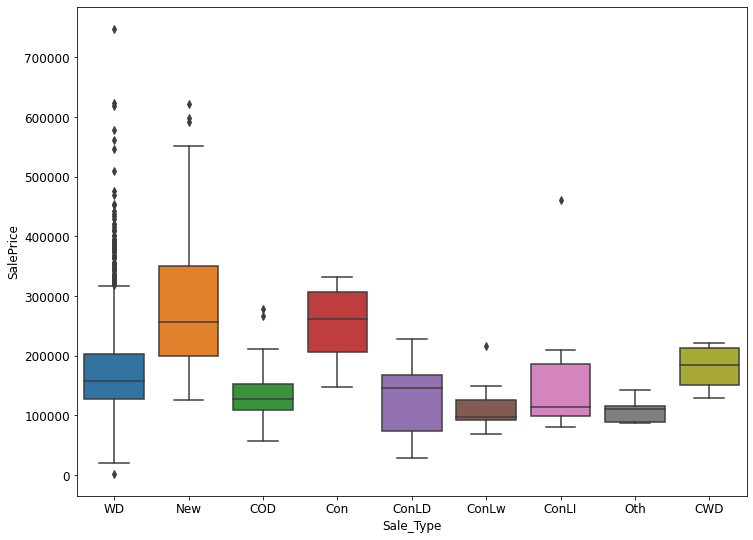

In [469]:
#your code here
sns.boxplot(x = training_data['Sale_Type'], y = (training_data["SalePrice"]), data = training_data)

**fancy answer goes here**
Only the features that are meaningfull are needed in the EDA. The sale price is the features that we have to base our search, and the sale type is a good indication. We can see that new house (their mean) are the most expensive one. With this plot give a good eye indication to give meaning to the information. Depending on the sale type, more search has to be done to have more infirmation to analyze the variables. 

#### Question 5 <a name="q5"></a>


Name a feature that isn't listed in this dataset but may be useful for predicting sales values. What insights could this feature provide? How might it increase or decrease a home’s sales value?

The energetic class of the house can be add as a feature. In Belgium we have to provide that when a house is sell, it's an indicator of the energy consumtion/insulation of the house, there is a scale from A++ for the best class to G for the worst one, with 18 different class.
It takes many features into account but it's a good indicator for the buyer as it do not aly take into acccount the consumation as big house will abiously consume more than small one but may have a better energetic class, so to rank the houses as we did in this clinic, I think it's a very good feature to add.



#### Question 6 <a name="q6"></a>

When evaluating your model, we used root mean squared error. Of course, in the context of our machine learning models that is great. However, In the context of estimating the value of houses, what does error mean for an individual homeowner? How does it affect them in terms of property taxes?

It's the estimated error in the value of the house that can affect the taxes the owner has to pay to the city. If the model is bias, some people may pay too much taxes, and other may pay less taxes as they would have to.

In the case of the Cook County Assessor’s Office, Chief Data Officer Rob Ross states that fair property tax rates are contingent on whether property values are assessed accurately - that they’re valued at what they’re worth, relative to properties with similar characteristics. This implies that having a more accurate model results in fairer assessments. The goal of the property assessment process for the CCAO, then, is to be as accurate as possible.

When the use of algorithms and statistical modeling has real-world consequences, we often refer to the idea of fairness as a measurement of how socially responsible our work is. But fairness is incredibly multifaceted: Is a fair model one that minimizes loss - one that generates accurate results? Is it one that utilizes "unbiased" data? Or is fairness a broader goal that takes historical contexts into account?

These approaches to fairness are not mutually exclusive. If we look beyond error functions and technical measures of accuracy, we'd not only consider individual cases of fairness, but also what fairness - and justice - means to marginalized communities on a broader scale. We'd ask: What does it mean when homes in predominantly Black and Hispanic communities in Cook County are consistently overvalued, resulting in proportionally higher property taxes? When the white neighborhoods in Cook County are consistently undervalued, resulting in proportionally lower property taxes?

Having "accurate" predictions doesn't necessarily address larger historical trends and inequities, and fairness in property assessments in taxes works beyond the CCAO's valuation model. Disassociating accurate predictions from a fair system is vital to approaching justice at multiple levels. Take Evanston, IL - a suburb in Cook County - as an example of housing equity beyond just improving a property valuation model: Their City Council members [recently approved reparations for African American residents](https://www.usnews.com/news/health-news/articles/2021-03-23/chicago-suburb-approves-government-reparations-for-black-residents).

As a final question to this (hopefully eye opening clinic), describe (in your own words) how you would define fairness in property assessments and taxes.

**fancy answer goes here**
It's really difficult to be faire with everyone in such a topic as there is many things that have to be taken into account, the model can easily be overfitted if too many features in the model. More reseaarch have to be done to see how the model responds on the different neighborhood, to see if the error is the same for every neighborhood, as we saw during this clinic, the previous model had some bias where some neighborhood were paying too much taxes and other less. So to have a fairness model more research than what I did have to be done. 